Load the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import re
import seaborn as sns
import nltk
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from time import sleep

In [2]:
order_items = pd.read_csv('data/bl_fulfillment_order_items.csv', 
                          dtype = {'id': str, 'order_id': str, 'product_id': str}, 
                          parse_dates=['created_at'])
order_states = pd.read_csv('data/bl_fulfillment_order_states.csv', 
                           dtype = {'id': str, 'order_id': str},
                           parse_dates=['created_at'])
orders = pd.read_csv('data/bl_fulfillment_orders.csv', 
                    dtype = {'id': str, 'purchaser_id': str, 'user_id': str},
                    parse_dates=['created_at'])

order_items.shape, order_states.shape, orders.shape

((825908, 6), (1453355, 4), (570071, 10))

In [3]:
order_items.head(10)

,id,order_id,name,price,product_id,created_at
0,245164,174553,Love You Forever,4.99,1298,2018-01-01 00:02:16
1,245169,174556,Boppy Bare Naked Pillow,29.99,3674,2018-01-01 00:12:38
2,245173,174560,Babylist Hello Baby Box - January,0.00,23177,2018-01-01 00:20:09
3,245178,174564,Goodnight Moon,6.99,1293,2018-01-01 00:27:33
4,245182,174567,Dr. Seuss's Sleep Softly Book,10.99,18207,2018-01-01 00:30:06
5,245187,174572,Boppy Bare Naked Pillow,29.99,3674,2018-01-01 00:38:19
6,245191,174573,Sassy Disposable Diaper Sacks (200 Count),6.99,4055,2018-01-01 00:38:40
7,245196,174576,FridaBaby NoseFrida The Snotsucker Nasal Aspir...,15.00,3659,2018-01-01 00:40:27
8,245200,174580,Doula Fund,100.00,NaN,2018-01-01 00:44:00
9,245205,174583,Babylist Hello Baby Box - January,0.00,23177,2018-01-01 00:50:26


In [4]:
order_states.head(10)

,id,order_id,state,created_at
0,506408,174552,open_order,2018-01-01 00:00:39
1,506412,174557,completed,2018-01-01 00:15:51
2,506416,174560,open_order,2018-01-01 00:20:09
3,506420,174565,open_order,2018-01-01 00:28:26
4,506424,174570,open_order,2018-01-01 00:30:27
5,506428,174574,open_order,2018-01-01 00:40:07
6,506432,174579,open_order,2018-01-01 00:43:24
7,506436,174584,open_order,2018-01-01 00:50:28
8,506440,174588,open_order,2018-01-01 01:00:18
9,506444,174593,completed,2018-01-01 01:08:06


In [5]:
orders.head(10)

,id,purchaser_id,user_id,state,total,subtotal,tax,shipping,created_at,order_type
0,174553,170816,NaN,shipped,90.97,90.97,0.00,0.00,2018-01-01 00:02:16,inventory
1,174558,170821,NaN,shipped,37.38,35.95,1.43,0.00,2018-01-01 00:19:12,inventory
2,174563,170826,1676888,shipped,0.00,0.00,0.00,0.00,2018-01-01 00:20:27,hello_baby_box
3,174567,170830,NaN,shipped,14.98,10.99,0.00,3.99,2018-01-01 00:30:06,inventory
4,174572,170835,1530699,shipped,32.65,29.99,2.66,0.00,2018-01-01 00:38:19,inventory
5,174577,170839,1676934,shipped,0.00,0.00,0.00,0.00,2018-01-01 00:40:28,hello_baby_box
6,174581,170843,1383961,shipped,193.50,193.50,0.00,0.00,2018-01-01 00:48:37,inventory
7,174586,170848,NaN,shipped,248.34,229.95,18.39,0.00,2018-01-01 00:54:29,inventory
8,174591,170853,NaN,shipped,19.23,13.99,1.25,3.99,2018-01-01 01:02:51,inventory
9,174596,170858,1676117,shipped,0.00,0.00,0.00,0.00,2018-01-01 01:10:27,hello_baby_box


# EDA

First, I want to explore each table to get a feel for what the columns mean, how the table is organized and what the summary statistics are, where relevant. 

## bl_fulfillment_orders

Let's start with the orders table

### Relationship between `purchaser_id` and `user_id`

In [6]:
orders[orders.duplicated('id')].shape

(0, 10)

In [7]:
orders[orders.duplicated('purchaser_id')].shape

(58731, 10)

Looks like the <b>orders</b> table is organized by `id`, which is a unique identifier of each order. `user_id` likely refers to users who have created an account (expecting mothers?!) and `purchaser_id` to users who made purchases with or without a babylist account. 

Let's quickly explore the relationship between `purchaser_id` and `user_id`

In [8]:
# filter out NAs in user_id
orders[~pd.isnull(orders.user_id)].shape, orders.shape

((282352, 10), (570071, 10))

Interestingly, roughly only ~50% of the entries have a `user_id`. The others are NAs. If these are expecting mothers, I would expect all of them to have an account and therefore, a user id. That there are NAs is odd. 

In [9]:
orders.user_id.value_counts()

1622402    56
1941793    32
1867656    26
1930595    25
1384347    25
           ..
1522382     1
2872129     1
2191758     1
1918310     1
2210782     1
Name: user_id, Length: 238756, dtype: int64

In [10]:
orders[orders.user_id=='1622402']

,id,purchaser_id,user_id,state,total,subtotal,tax,shipping,created_at,order_type
302,175924,172163,1622402,shipped,74.88,69.99,4.89,0.00,2018-01-02 18:59:57,inventory
983,176038,172273,1622402,shipped,107.76,98.99,8.77,0.00,2018-01-02 20:21:22,inventory
9776,201925,197885,1622402,shipped,84.99,84.99,0.00,0.00,2018-01-16 20:02:12,inventory
12092,176114,172351,1622402,completed,100.00,100.00,0.00,0.00,2018-01-02 21:34:26,electronic_gift_card
13545,179555,175749,1622402,shipped,80.00,80.00,0.00,0.00,2018-01-04 21:11:03,inventory
14320,182358,178535,1622402,shipped,64.80,59.99,4.81,0.00,2018-01-06 18:55:29,inventory
28465,237463,232998,1622402,completed,200.00,200.00,0.00,0.00,2018-02-02 22:08:27,electronic_gift_card
40419,251585,246679,1622402,shipped,152.38,139.97,12.41,0.00,2018-02-14 22:19:03,inventory
42469,260751,255548,1622402,completed,50.00,50.00,0.00,0.00,2018-02-21 22:34:18,electronic_gift_card
48823,245489,240749,1622402,shipped,130.80,120.00,10.80,0.00,2018-02-09 22:32:27,inventory


In [11]:
orders[orders.user_id=='1622402'].total.sum()

5400.79

Ok, a single `user_id` may have several `purchaser_id`s associated with it along with a rather large total \\$ value of orders indicating that `user_id` is a registry account opened by an expecting mother. What about `purchaser_id` -- are there several of these?

In [12]:
orders.purchaser_id.value_counts()

297273    25
289445    18
195173    17
353423    17
282941    16
          ..
646496     1
463405     1
328447     1
347598     1
271626     1
Name: purchaser_id, Length: 511340, dtype: int64

In [13]:
orders[orders.purchaser_id.isin(['297273', '289445'])].sort_values('user_id')

,id,purchaser_id,user_id,state,total,subtotal,tax,shipping,created_at,order_type
299961,525303,289445,1917107,shipped,154.32,139.92,14.4,0.0,2018-09-13 18:49:47,inventory
102239,334598,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 19:23:14,hello_baby_box
102241,334606,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 19:28:54,hello_baby_box
102292,334853,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 21:43:32,hello_baby_box
107620,334937,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 22:26:43,hello_baby_box
107632,334993,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 22:52:20,hello_baby_box
128075,334601,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 19:23:55,hello_baby_box
128144,334935,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 22:24:20,hello_baby_box
128121,334824,289445,1917107,cancelled,0.00,0.00,0.0,0.0,2018-04-11 21:28:45,hello_baby_box
84403,295999,289445,1917107,shipped,NaN,NaN,NaN,NaN,2018-03-17 20:31:45,hello_baby_box


Weird! There are several duplicate `purchaser_id` entries but they seem to be associated with only one `user_id`. Two things to explore further: 
- Why are there NAs in `user_id`? 
- The duplicate `purchaser_id` seem to have mostly cancelled orders. Why is that the case? What is going on here? 

### `total` cost of the order

In [14]:
orders.total.describe()

count    477387.000000
mean         66.765387
std          86.456213
min           0.000000
25%           4.950000
50%          47.930000
75%          81.670000
max        5000.000000
Name: total, dtype: float64

A right-skewed distribution, which is to be expected. Few family members and close friends would buy expensive items like cribs, but most of the other people would be expected to spend much less. Let's visualize this on the regular and log scales 

[Text(0.5, 0, 'Log of Total Order Cost')]

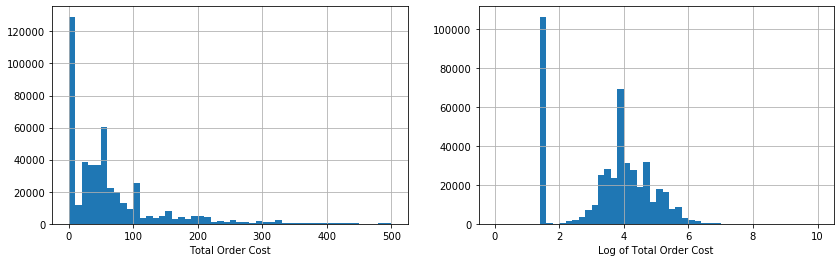

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
orders.total.hist(bins=50, range=(0, 500), ax=ax1).set(xlabel='Total Order Cost')
np.log(orders.total+10**-19).hist(bins=50, range=(0, 10), ax=ax2).set(xlabel='Log of Total Order Cost')

Appears to be an approximately lognormal distribution. There is a huge peak at \\$0.0, which is likely due to the Hello Baby Box items. The plot on the left also indicates that there are buckets of spending categories. People like to spend at the thresholds of \\$50, \\$100, \\$150, etc. 

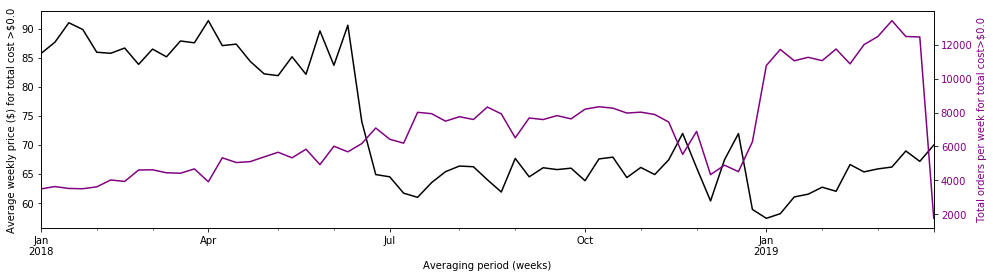

In [16]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

# Filter out zeros
orders.total[orders.total>0.0] \
    .groupby([orders.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax1, color='black')

orders.id[orders.total>0.0] \
    .groupby([orders.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='purple')

ax1.set(xlabel='Averaging period (weeks)', ylabel='Average weekly price (\\$) for total cost >$0.0')
ax2.set_ylabel('Total orders per week for total cost>$0.0', color='purple')
ax2.tick_params(labelcolor='purple')

Couple of things to note here and explore further:
1. There is a huge drop off in average price in July 2018 and then some fluctuations in Oct and Dec 2018
2. Total cost of an order and order volume seem unrelated 

Might be able to parse this out based on `order_type` and/or seasonal effects.  We have `created_at` feature that might help.

### `created_at` and `order_type`

[Text(0, 0.5, 'Total Orders per month'),
 Text(0.5, 0, 'Averaging period (in months)')]

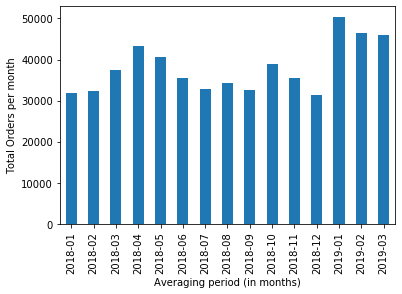

In [17]:
orders.id \
    .groupby(orders.created_at.dt.to_period('M')).count() \
    .plot(kind='bar').set(xlabel='Averaging period (in months)', ylabel='Total Orders per month')

Looks like there is a certain periodocity to user purchasing behavior, with the same odd spike in January we saw before. Something is happening behind the scenes so let's explore this further. May have something to do with `order_type`

In [18]:
orders.order_type.value_counts()

hello_baby_box          218016
inventory               175404
shopify                 113091
electronic_gift_card     43930
cash                     16720
drop_ship                 2910
Name: order_type, dtype: int64

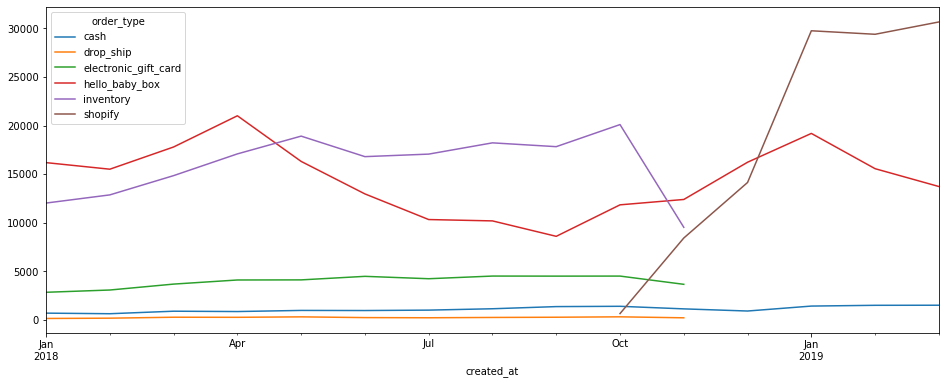

In [19]:
orders \
    .groupby([orders.created_at.dt.to_period('M'), orders.order_type]) \
    .count()['created_at'].unstack().plot(figsize=(16, 6))

Aha! Some interesting patterns jump out here: 
1. The 'inventory', 'electronic_gift_card' and 'drop_ship' data are only available until Nov 2018. Elecronic gift card and drop-ship sales stay pretty constant, but the inventory sales were on a general upward trend until Oct 2018

2. Starting in Oct 2018, there is a huge spike in 'shopify' orders. One explanation is that the operations were starting to transition over to shopify in about Oct 2018 and were fully transitioned by Nov 2018. This makes some sense b/c the negative slope for inventory from Oct to Nov 2018 is pretty much the complement of positive slope of shopify from Oct to Nov 2018 indicting that the loss in inventory sales is proportional to the gain in shopify sales. The upward trend in inventory-based sales; the additive effect of inventory, electronic gift cards and drop ship sales; and perhaps some operational gains from transitioning over to a professional ecommerce software like shopify make this a fairly likely hypothesis to me
3. The periodic effect in the previous graph is mostly due to the 'hello_baby_box' orders. Not sure the reason for this, but perhaps birth rates are higher in fall and early summer and therefore more registries are created during spring and winter.  This would be an interesting trend to parse further. 

Since electronic gift cards, drop ship and inventory stop at exactly the same time as shopify starts to ramp up, assumption is that all of these were rolled into shopify where as hello baby box and cash are still managed by BL separately.  Let's filter the table to remove hello baby box and cash

In [20]:
sub_orders = orders[orders.order_type.isin(['inventory', 'shopify', 'drop_ship', 'electronic_gift_card'])]
sub_orders.shape

(335335, 10)

Let's plot the bar plot from above again with the filtered data set

[Text(0, 0.5, 'Total Orders per month'), Text(0.5, 0, 'Month')]

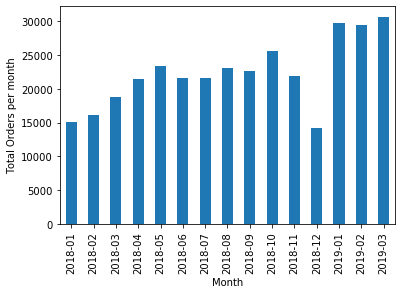

In [21]:
sub_orders.id \
    .groupby(sub_orders.created_at.dt.to_period('M')).count() \
    .plot(kind='bar').set(xlabel='Month', ylabel='Total Orders per month')

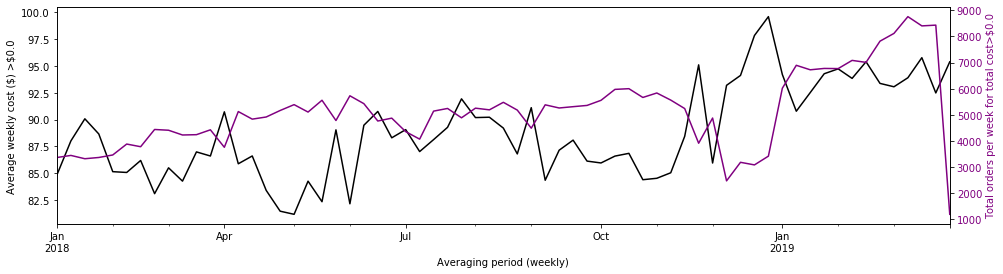

In [22]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

# Filter out zeros
sub_orders.total[sub_orders.total>0.0] \
    .groupby([sub_orders.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax1, color='black')

sub_orders.id[sub_orders.total>0.0] \
    .groupby([sub_orders.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='purple')

ax1.set(xlabel='Averaging period (weekly)', ylabel='Average weekly cost (\\$) >$0.0')
ax2.set_ylabel('Total orders per week for total cost>$0.0', color='purple')
ax2.tick_params(labelcolor='purple')

The exaggerated periodic behavior is gone, but there are still wild swings in total order cost relative to fairly stable volume growth. There is still some indication of periodicity and that drop off in Oct, 2018. 

Let's switch gears.  I'm curious about these 'drop_ship' products

In [23]:
sub_orders[sub_orders.order_type=='drop_ship'].total.describe()

count    2910.000000
mean      258.635340
std       112.752428
min         0.000000
25%       199.000000
50%       259.000000
75%       316.460000
max      1087.490000
Name: total, dtype: float64

In [24]:
sub_orders[sub_orders.order_type=='inventory'].total.describe()

count    175404.000000
mean         84.865885
std          84.660667
min           0.000000
25%          35.360000
50%          54.470000
75%          97.190000
max        2295.720000
Name: total, dtype: float64

Interesting. 'drop_ship' products are on average more expensive than those in the 'inventory'. Let's see what these products actually are

In [25]:
tmp = pd.merge(sub_orders[sub_orders.order_type=='drop_ship'].id, 
         order_items[['order_id', 'name', 'price']], 
         left_on='id', right_on='order_id')
tmp.name

0       Lullaby Earth 2-Stage Super Lightweight Crib M...
1       Lullaby Earth 2-Stage Super Lightweight Crib M...
2       Lullaby Earth 2-Stage Super Lightweight Crib M...
3       Lullaby Earth 2-Stage Super Lightweight Crib M...
4                      babyletto Gelato Mini Crib - White
                              ...                        
2915    babyletto Gelato 4-in-1 Convertible Crib with ...
2916     babyletto Hudson 3-in-1 Convertible Crib - White
2917    Lullaby Earth 2-Stage Super Lightweight Crib M...
2918     babyletto Hudson 3-in-1 Convertible Crib - White
2919           Lullaby Earth Breeze Crib Mattress - White
Name: name, Length: 2920, dtype: object

For the most part, these look like cribs or crib-related items

In [26]:
tmp[tmp.name.str.contains('Crib')].shape

(1917, 4)

In [27]:
1833/2803

0.6539422047805922

Roughly 65% of drop_ship are cribs. What are the others? Let's do a simple BOW

In [28]:
tmp.name[~tmp.name.str.contains('Crib')]

6       babyletto Universal Removable Changing Tray - ...
7                     OXO Tot Sprout Chair - Taupe/Walnut
12                 babyletto Spruce Tree Bookcase - White
18      Lorena Canals Bereber Classic Washable Rug - B...
19      Lorena Canals Morocco Washable Rug - Naador 4'...
                              ...                        
2904    Halo Twin Bassinest Swivel Sleeper Luxe Series...
2905    Lorena Canals Morocco Washable Rug - Kaarol 4'...
2910           Petit Pehr Round Rug - Peek A Boo Pink, 5'
2913    Oribel Cocoon 3 Stage Modern High Chair - Pist...
2914    Halo Twin Bassinest Swivel Sleeper Luxe Series...
Name: name, Length: 1003, dtype: object

In [29]:
cv = CountVectorizer(max_features=10)
features = cv.fit_transform(tmp.name[~tmp.name.str.contains('Crib')])
cv.get_feature_names(), features.sum(axis=0)

(['150',
  'babyletto',
  'chair',
  'classic',
  'naturepedic',
  'oxo',
  'sprout',
  'tot',
  'tray',
  'white'],
 matrix([[161, 270, 262, 175, 161, 196, 196, 196, 258, 264]], dtype=int64))

Not super helpful, but these may contain chairs and other relatively more expensive items that BL chooses to ship directly from supplier. Anyway, though biased high in terms of price, drop_ship is a relatively small fraction of total sales. Something to keep in mind. 

Let's look at the other two tables briefly

## bl_fulfillment_order_items

### `product_id`

In [30]:
order_items.head()

,id,order_id,name,price,product_id,created_at
0,245164,174553,Love You Forever,4.99,1298,2018-01-01 00:02:16
1,245169,174556,Boppy Bare Naked Pillow,29.99,3674,2018-01-01 00:12:38
2,245173,174560,Babylist Hello Baby Box - January,0.00,23177,2018-01-01 00:20:09
3,245178,174564,Goodnight Moon,6.99,1293,2018-01-01 00:27:33
4,245182,174567,Dr. Seuss's Sleep Softly Book,10.99,18207,2018-01-01 00:30:06


In [31]:
order_items.product_id.describe()

count     809187
unique      5817
top        19106
freq       43958
Name: product_id, dtype: object

~5,000 SKUs as mentioned in the assignment. Some of these are gift cards, cash and hello baby box items as well

### `price`

In [32]:
order_items.price.describe()

count    825908.000000
mean         36.529107
std          63.471279
min           0.000000
25%           0.000000
50%          15.990000
75%          39.990000
max        1249.950000
Name: price, dtype: float64

[Text(0.5, 0, 'Log Price')]

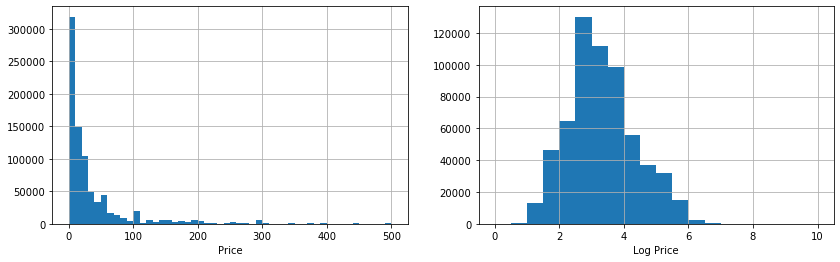

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
order_items.price.hist(bins=50, range=(0, 500), ax=ax1).set(xlabel='Price')
np.log(order_items.price+10**-19).hist(bins=20, range=(0, 10), ax=ax2).set(xlabel='Log Price')

Approximately lognormal again as expected. Above I used total cost of the order as a surrogate for examining price-related trends. Using the <b>order_items</b> we can actually examine price-related trend specific to each item

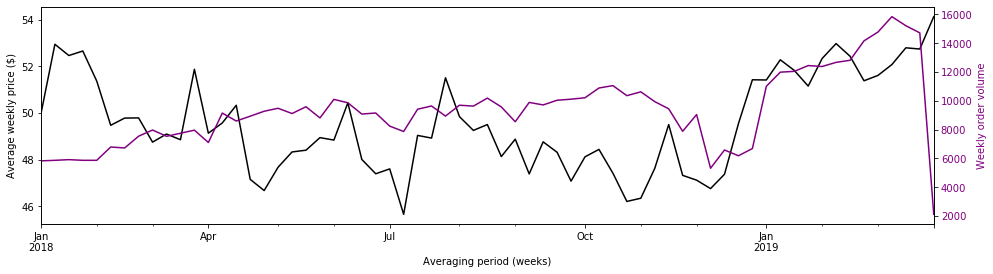

In [35]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

# Filter out zeros
order_items.price[order_items.price>0.0] \
    .groupby([order_items.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax1, color='black')

order_items.id[order_items.price>0.0] \
    .groupby([order_items.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='purple')

ax1.set(xlabel='Averaging period (weeks)', ylabel='Average weekly price (\\$)')
ax2.set_ylabel('Weekly order volume', color='purple')
ax2.tick_params(labelcolor='purple')

Roughly the same relationship, but with a lot of interesting things happening on a micro scale, especially in the December time frame when there is the drop off. 

Is there any relationship between the items being ordered, their price and the order volume? Let's first merge the <b>orders</b> and the <b>order_items</b> tables and then do a BOW to find the most popular item categories. We can then use that to compare item-specific prices and order volume

In [36]:
df_ooi = pd.merge(sub_orders[['id', 'purchaser_id', 'user_id', 'total', 'state', 'order_type', 'created_at']], 
               order_items[['order_id', 'product_id', 'name', 'price']],
               left_on='id', right_on='order_id')

# Let's get rid of gift card items
# pre-shopify is easy: just get rid of the 'electronic_gift_card' category fom order_type
df_ooi = df_ooi[df_ooi.order_type!='electronic_gift_card']

# post-shopify: get rid of items that contain the string "Store Gift Card" in name
df_ooi = df_ooi[~df_ooi.name.str.contains('Store Gift Card')]

df_ooi.shape

(530372, 11)

In [37]:
df_ooi[df_ooi.price==0.0]

,id,purchaser_id,user_id,total,state,order_type,created_at,order_id,product_id,name,price
641,174778,171036,1589111,3.99,cancelled,inventory,2018-01-01 10:48:52,174778,23177,Babylist Hello Baby Box - January,0.0
1088,177170,173386,1660744,3.99,cancelled,inventory,2018-01-03 20:20:42,177170,23177,Babylist Hello Baby Box - January,0.0
1928,176679,172903,NaN,3.99,cancelled,inventory,2018-01-03 07:22:56,176679,23177,Babylist Hello Baby Box - January,0.0
4203,185394,181534,1604067,3.99,cancelled,inventory,2018-01-08 17:22:52,185394,23177,Babylist Hello Baby Box - January,0.0
5218,189578,185654,611883,112.50,shipped,inventory,2018-01-11 01:50:37,189578,23177,Babylist Hello Baby Box - January,0.0
24159,243278,238616,1384347,0.00,shipped,inventory,2018-02-07 22:51:11,243278,3783,Safety 1st Sleepy Baby Nail Clipper With Built...,0.0
24160,243278,238616,1384347,0.00,shipped,inventory,2018-02-07 22:51:11,243278,15436,Aden + Anais Muslin Washcloths (3 Pack) - Jung...,0.0
24161,243278,238616,1384347,0.00,shipped,inventory,2018-02-07 22:51:11,243278,21407,Puracy Natural Baby Shampoo & Body Wash - Citr...,0.0
24162,243278,238616,1384347,0.00,shipped,inventory,2018-02-07 22:51:11,243278,3749,Earth Mama Angel Baby Organic Diaper Balm - 2 oz,0.0
24163,243278,238616,1384347,0.00,shipped,inventory,2018-02-07 22:51:11,243278,3783,Safety 1st Sleepy Baby Nail Clipper With Built...,0.0


In [38]:
# some items are priced at 0.0 though they were shipped. Maybe lost items
df_ooi = df_ooi[df_ooi.price != 0.0]
df_ooi.shape

(530351, 11)

In [39]:
# Function to clean up names
wpt = nltk.WordPunctTokenizer()

stop_words = nltk.corpus.stopwords.words('english')
# Some words for this data set are not very helpful, for e.g., 'baby', 'infant', 'oz'
stop_words = stop_words + ['baby', 'infant', 'oz']
stop_words = set(stop_words) # much faster than a list

def clean_text(text):
    # lower case, remove special characters, and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    # tokenize
    tokens = wpt.tokenize(text)
    
    # filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join text back
    text = ' '.join(filtered_tokens)
    return text

names = df_ooi['name'].apply(lambda x: clean_text(x))
names

0                                              love forever
1                                 brown bear brown bear see
2                      graco pack n play playard go stratus
3                          philips avent fast bottle warmer
4                                dr seuss sleep softly book
                                ...                        
591131                      sprouts toy chest grey elephant
591132             skip hop moby waterfall bath rinser grey
591133          banz hearing protection earmuffs petal pink
591134                     ergobaby omni carrier pure black
591136    keekaroo height right highchair insert tray na...
Name: name, Length: 530351, dtype: object

In [40]:
# BOW to infer the most popular item categories
cv = CountVectorizer(max_features=50, ngram_range=(1,2))
features = cv.fit_transform(names)
word_frequencies = list(zip(cv.get_feature_names(), np.asarray(features.sum(axis=0))[0]))
word_frequencies

[('black', 25120),
 ('blue', 21534),
 ('boon', 14784),
 ('boppy', 21375),
 ('bottle', 30447),
 ('brown', 16295),
 ('car', 14167),
 ('car seat', 13982),
 ('carrier', 15591),
 ('changing', 20106),
 ('changing pad', 15988),
 ('classic', 19727),
 ('copper', 13634),
 ('copper pearl', 13634),
 ('cotton', 19723),
 ('cover', 21982),
 ('crib', 13493),
 ('diaper', 21641),
 ('dr', 13253),
 ('go', 13313),
 ('gray', 15317),
 ('green', 22616),
 ('grey', 50845),
 ('halo', 14156),
 ('hop', 35313),
 ('light', 13772),
 ('little', 17264),
 ('little unicorn', 13468),
 ('months', 29279),
 ('munchkin', 15523),
 ('muslin', 16049),
 ('newborn', 19483),
 ('night', 12904),
 ('nursing', 14327),
 ('organic', 21808),
 ('pacifier', 20210),
 ('pack', 65631),
 ('pad', 20674),
 ('pearl', 14519),
 ('philips', 12771),
 ('pink', 16470),
 ('rack', 13060),
 ('seat', 24100),
 ('set', 17449),
 ('skip', 35313),
 ('skip hop', 35313),
 ('swaddle', 17239),
 ('ubbi', 13018),
 ('unicorn', 14065),
 ('white', 36245)]

In [41]:
sorted(word_frequencies, key=lambda x: x[1], reverse=True)

[('pack', 65631),
 ('grey', 50845),
 ('white', 36245),
 ('hop', 35313),
 ('skip', 35313),
 ('skip hop', 35313),
 ('bottle', 30447),
 ('months', 29279),
 ('black', 25120),
 ('seat', 24100),
 ('green', 22616),
 ('cover', 21982),
 ('organic', 21808),
 ('diaper', 21641),
 ('blue', 21534),
 ('boppy', 21375),
 ('pad', 20674),
 ('pacifier', 20210),
 ('changing', 20106),
 ('classic', 19727),
 ('cotton', 19723),
 ('newborn', 19483),
 ('set', 17449),
 ('little', 17264),
 ('swaddle', 17239),
 ('pink', 16470),
 ('brown', 16295),
 ('muslin', 16049),
 ('changing pad', 15988),
 ('carrier', 15591),
 ('munchkin', 15523),
 ('gray', 15317),
 ('boon', 14784),
 ('pearl', 14519),
 ('nursing', 14327),
 ('car', 14167),
 ('halo', 14156),
 ('unicorn', 14065),
 ('car seat', 13982),
 ('light', 13772),
 ('copper', 13634),
 ('copper pearl', 13634),
 ('crib', 13493),
 ('little unicorn', 13468),
 ('go', 13313),
 ('dr', 13253),
 ('rack', 13060),
 ('ubbi', 13018),
 ('night', 12904),
 ('philips', 12771)]

Some of the words that jump out from above are 'bottle', 'pacifier', 'diaper', 'swaddle', 'changing pad' and 'car seat'. That's enough to get some ideas of item-specific price trends

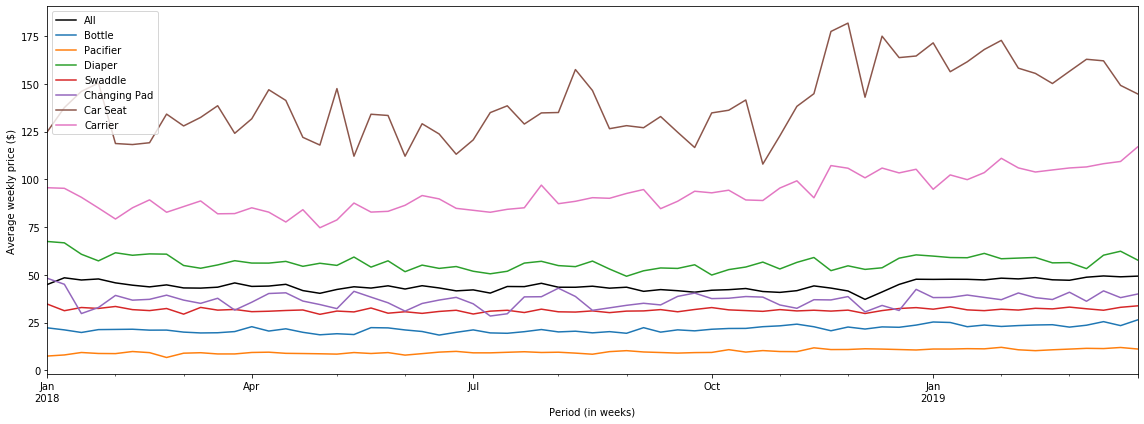

In [42]:
fig, ax = plt.subplots(figsize=(16, 6))

df_ooi.price \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax, color='black')

categories = ['Bottle', 'Pacifier', 'Diaper', 'Swaddle', 'Changing Pad', 'Car Seat', 'Carrier']
for cat in categories:
    df_ooi.price[df_ooi.name.str.contains(cat)] \
        .groupby([df_ooi.created_at.dt.to_period('W')]) \
        .mean().plot(ax=ax)

ax.legend(['All']+categories)
ax.set(xlabel='Period (in weeks)', ylabel='Average weekly price ($)')
fig.tight_layout()

Prices of swaddle, pacifier,bottle are fairly constant relative to carrier, changing pad and car seat, whic are highly variable. Diaper variability is somewhat in the middle. 

Initially, I had assumed that the dropoff in late Fall was due to the transition to shopify, but the mean price shouldn't have changed if that were the case. Something else is driving this dropoff. It's not the car seat b/c the price is actually going up as opposed to the mean price of all items. 

A better measure would be a multiplier of price and volume or a percent change from mean value. That would adjust for the absolute differences in price (not done here).

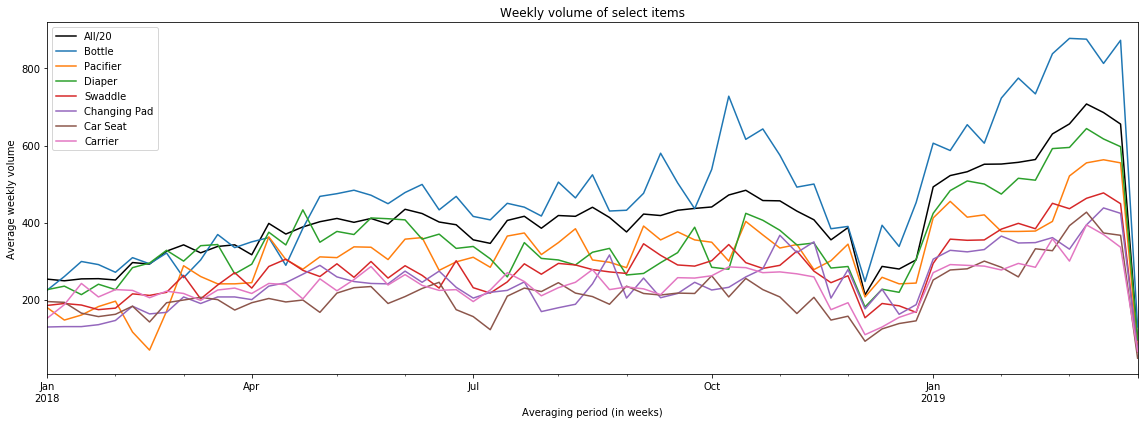

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))

(df_ooi.price \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .count()/20).plot(ax=ax, color='black')

categories = ['Bottle', 'Pacifier', 'Diaper', 'Swaddle', 'Changing Pad', 'Car Seat', 'Carrier']
for cat in categories:
    df_ooi.price[df_ooi.name.str.contains(cat)] \
        .groupby([df_ooi.created_at.dt.to_period('W')]) \
        .count().plot(ax=ax)

ax.legend(['All/20']+categories)
ax.set_title('Weekly volume of select items')
ax.set(xlabel='Averaging period (in weeks)', ylabel='Average weekly volume')
fig.tight_layout()

There is some item-specific variability but overall volume of everything decreases right around late Fall. Bottle volume and car seat volume changes are more pronounced than other items. 

## bl_fulfillment_order_state

In [44]:
order_states.head()

,id,order_id,state,created_at
0,506408,174552,open_order,2018-01-01 00:00:39
1,506412,174557,completed,2018-01-01 00:15:51
2,506416,174560,open_order,2018-01-01 00:20:09
3,506420,174565,open_order,2018-01-01 00:28:26
4,506424,174570,open_order,2018-01-01 00:30:27


In [45]:
order_states.state.value_counts()

shipped                                                                                                                                           504225
open_order                                                                                                                                        398647
ordered                                                                                                                                           220213
prepare_shipment                                                                                                                                  218943
completed                                                                                                                                          60605
                                                                                                                                                   ...  
fraud hold added by system -  ip address 104.34.89.8 placed too many orders       

Oddly, there are comments in the state column. This may be helpful in answering why there are NA `user_id`s and other questions. 

In [46]:
order_states[~order_states.state.str.contains('hold')].state.value_counts()

shipped              504225
open_order           398647
ordered              220213
prepare_shipment     218943
completed             60605
partially_shipped      8682
cancelled              5714
Name: state, dtype: int64

In [47]:
order_states[~order_states.state.str.contains('hold')].shape, order_states.shape

((1417029, 4), (1453355, 4))

In [48]:
1417029/1453355

0.9750054184972013

Only about 2.5% of the entries are actually held

In [49]:
len(order_states.order_id.unique()), len(orders)

(571598, 570071)

Roughly the same so that's a good thing

In [50]:
order_states[order_states.order_id=='174552']

,id,order_id,state,created_at
0,506408,174552,open_order,2018-01-01 00:00:39
77996,579883,174552,ordered,2018-01-31 01:27:55
131052,611160,174552,shipped,2018-02-08 17:07:38


Nearly a month before the order is actually shipped after the order is opened. This item may have had a low inventory. 

In [51]:
order_items[order_items.order_id=='174552']

,id,order_id,name,price,product_id,created_at
17404,245163,174552,Babylist Hello Baby Box - January,0.0,23177,2018-01-01 00:00:39


Nevermind. This is a hello baby box item. Perhaps they are all ordered and then shipped at the end of each month. Have to look into this data set further for: 
1. How long does it take for a typical order to get shipped out?
2. Why are orders cancelled? Is it due to delay in shipping?

# BL questions

Some of the trends I'm interested in will be answered by analyzing BL questions. 

## Question 1

How healthy are our sales?
 - What’s our average daily order volume and how has it changed over time?
 - Are there any patterns that emerge from the order volatility?
 - Analyze orders containing bottles. Are there any patterns/trends that you notice?


In [52]:
df_ooi.head()

,id,purchaser_id,user_id,total,state,order_type,created_at,order_id,product_id,name,price
0,174553,170816,NaN,90.97,shipped,inventory,2018-01-01 00:02:16,174553,1298,Love You Forever,4.99
1,174553,170816,NaN,90.97,shipped,inventory,2018-01-01 00:02:16,174553,1309,"Brown Bear, Brown Bear, What Do You See?",5.99
2,174553,170816,NaN,90.97,shipped,inventory,2018-01-01 00:02:16,174553,16616,Graco Pack 'n Play Playard On The Go - Stratus,79.99
3,174558,170821,NaN,37.38,shipped,inventory,2018-01-01 00:19:12,174558,15833,Philips Avent Fast Bottle Warmer,35.95
4,174567,170830,NaN,14.98,shipped,inventory,2018-01-01 00:30:06,174567,18207,Dr. Seuss's Sleep Softly Book,10.99


In [53]:
# Let's make sure gift cards, hello baby boxes, etc. are not included
df_ooi.order_type.value_counts()

inventory    345640
shopify      181791
drop_ship      2920
Name: order_type, dtype: int64

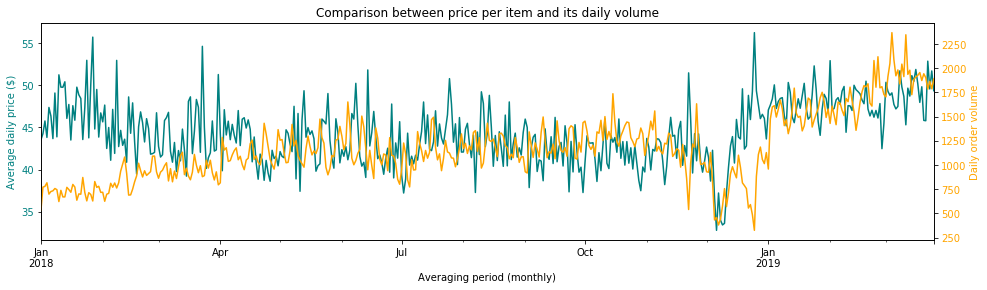

In [54]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

df_ooi.price \
    .groupby([df_ooi.created_at.dt.to_period('D')]) \
    .mean().plot(ax=ax1, color='teal')

df_ooi.product_id \
    .groupby([df_ooi.created_at.dt.to_period('D')]) \
    .count().plot(ax=ax2, color='orange')

ax1.set_title('Comparison between price per item and its daily volume')
ax1.set_xlabel('Averaging period (monthly)')
ax1.set_ylabel('Average daily price (\\$)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Daily order volume', color='orange')
ax2.tick_params(labelcolor='orange')

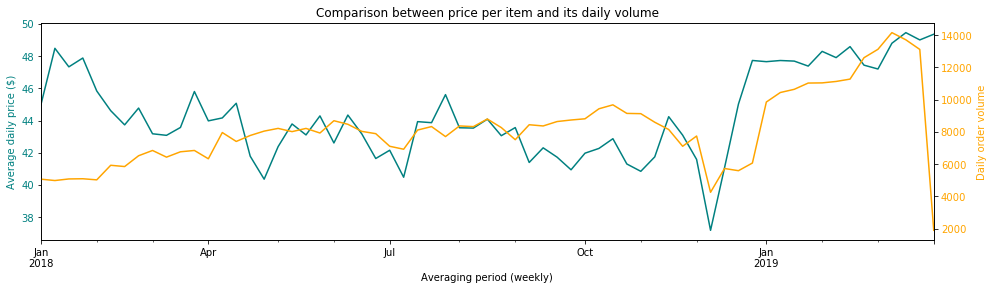

In [55]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

df_ooi.price \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax1, color='teal')

df_ooi.product_id \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='orange')

ax1.set_title('Comparison between price per item and its daily volume')
ax1.set_xlabel('Averaging period (weekly)')
ax1.set_ylabel('Average daily price (\\$)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Daily order volume', color='orange')
ax2.tick_params(labelcolor='orange')

As noted earlier, on the whole, price and order volume seem to have little correlation to each other. While the price fluctuates quite a bit, there is a general increase in sales with a linear trend until about June after which the slope is ~0, i.e., sales remain relatively constant. In January, sales start picking up again, with in fact a higher slope than before, which may be due to a transition to shopify. 

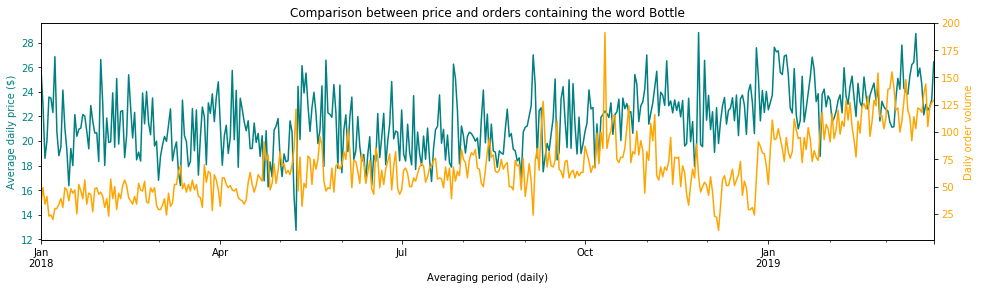

In [56]:
# Let's analyze for items containing 'Bottle'

fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

df_ooi.price[df_ooi.name.str.contains('Bottle')] \
    .groupby([df_ooi.created_at.dt.to_period('D')]) \
    .mean().plot(ax=ax1, color='teal')

df_ooi.product_id[df_ooi.name.str.contains('Bottle')] \
    .groupby([df_ooi.created_at.dt.to_period('D')]) \
    .count().plot(ax=ax2, color='orange')

ax1.set_title('Comparison between price and orders containing the word Bottle')
ax1.set_xlabel('Averaging period (daily)')
ax1.set_ylabel('Average daily price (\\$)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Daily order volume', color='orange')
ax2.tick_params(labelcolor='orange')

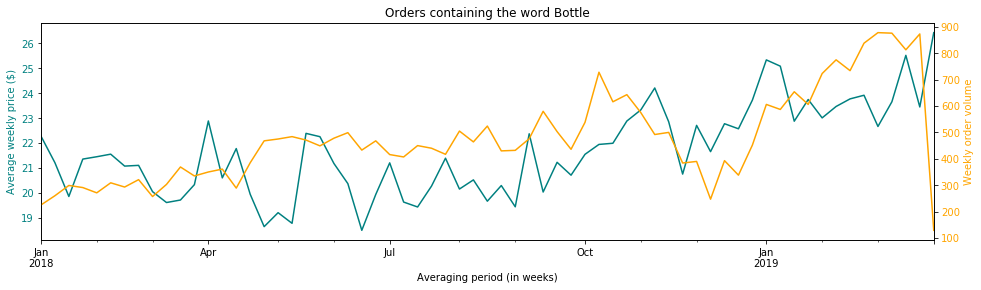

In [57]:
# Let's analyze for items containing 'Bottle'

fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

df_ooi.price[df_ooi.name.str.contains('Bottle')] \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .mean().plot(ax=ax1, color='teal')

df_ooi.product_id[df_ooi.name.str.contains('Bottle')] \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='orange')

ax1.set_title('Orders containing the word Bottle')
ax1.set_xlabel('Averaging period (in weeks)')
ax1.set_ylabel('Average weekly price (\\$)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Weekly order volume', color='orange')
ax2.tick_params(labelcolor='orange')

The price does not seem to be driving bottle-buying behavior, e.g., May and Jun 2018 price decrease doesn't influence the sales nearly as much as the price drop. Same holds true even in late December/early January where despite the price increase, sales are on the up. There is a fairly linear increase in bottle sales regardless of price. The slope is higher after the transition to shopify, which may be due to better managed inventory and other tools that shopify offers

The exception continues to be Nov 2018, which perhaps merits a detailed look, but I'm going to assume that it was due to transition to shopify and something unlikely to repeat again

## Question 2

Come up with a question of your own about the health of our e-commerce business. Try to answer your own question using the provided data set. Include your question, hypotheses, and results in your project presentation.

In [66]:
from scipy.stats import pearsonr

corr, _ = pearsonr(
    df_ooi.price.groupby([df_ooi.created_at.dt.to_period('W')]).mean().values,
    df_ooi.id.groupby([df_ooi.created_at.dt.to_period('W')]).count().values)

"Pearson's correlation coefficient:", corr

("Pearson's correlation coefficient:", 0.30519795607262357)

As I have shown before the correlation between price and order volume is rather low. While there are some micro price-related trends, the variability in price does not explain the fairly constant upward linear trend in order volume. There are several potential hypotheses but I'll explore the following two: 
1. The number of users, i.e., expecting mothers, has increased over time b/c of Babylist's growth
2. The number of items being offered through Babylist inventory has grown

### Hypothesis 1: # of users has increased over time

We have a lot of user ids that are NAs, which needs to be looked at further. But I'll assume that the number of NAs is proportional to the number of valid user ids for a given period. Still have to wrangle the table to get unique user_ids though

In [67]:
tmp = df_ooi.drop_duplicates(subset=['user_id'])[1:]
tmp.head()

,id,purchaser_id,user_id,total,state,order_type,created_at,order_id,product_id,name,price
5,174572,170835,1530699,32.65,shipped,inventory,2018-01-01 00:38:19,174572,3674,Boppy Bare Naked Pillow,29.99
6,174581,170843,1383961,193.50,shipped,inventory,2018-01-01 00:48:37,174581,21191,Baby Bling Knot Headband - Lilac,9.00
14,174615,159254,1434766,52.95,shipped,inventory,2018-01-01 01:45:17,174615,3765,The First Years Breastflow Milk Storage Organizer,13.49
19,174640,170900,1494431,212.82,shipped,inventory,2018-01-01 02:40:13,174640,5939,Medela Disposable Nursing Bra Pads - 120,13.04
29,174712,170971,1402673,261.74,shipped,inventory,2018-01-01 05:19:40,174712,21217,Roshambo Baby Shades Strap and Ear Adjuster Kit,1.80


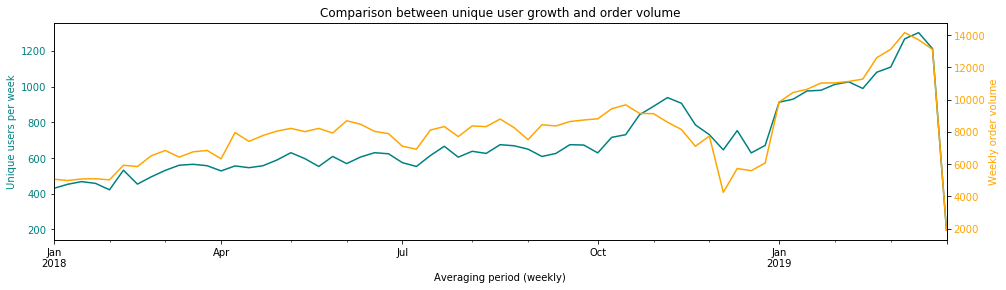

In [68]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

tmp.groupby(tmp.created_at.dt.to_period('W')).count()['user_id'] \
    .plot(ax=ax1, color='teal')

df_ooi.product_id \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .count().plot(ax=ax2, color='orange')

ax1.set_title('Comparison between unique user growth and order volume')
ax1.set_xlabel('Averaging period (weekly)')
ax1.set_ylabel('Unique users per week', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Weekly order volume', color='orange')
ax2.tick_params(labelcolor='orange')

The graph above is a pretty good evidence there is that the BL platform is growing, which is directly proportional to more sales. 

### Hypothesis 2: Babylist inventory has grown 

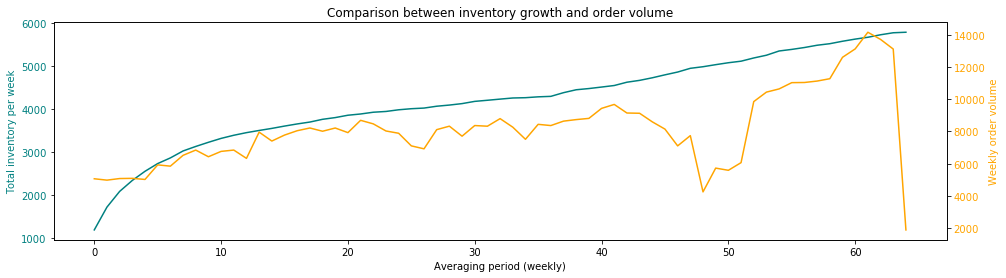

In [69]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

tmp = df_ooi.drop_duplicates(subset=['product_id'])[1:]
ax1.plot(
    np.cumsum(
        tmp.groupby(tmp.created_at.dt.to_period('W')) \
            .count()['product_id'].values), 
    color='teal')

ax2.plot(df_ooi.product_id \
    .groupby([df_ooi.created_at.dt.to_period('W')]) \
    .count().values, color='orange')

ax1.set_title('Comparison between inventory growth and order volume')
ax1.set_xlabel('Averaging period (weekly)')
ax1.set_ylabel('Total inventory per week', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_ylabel('Weekly order volume', color='orange')
ax2.tick_params(labelcolor='orange')

Graph does indicate that inventory growth is related to higher order volume especially because the inventory growth curve almost looks like a linear regression fit to the sales volume. Caveat though is that more inventory doesn't necessarily mean sale of the newer items, i.e., people could just be buying more of the older stuff. 

## Question 3

Based on your understanding of Babylist’s business and from looking at the data, propose at least one operational metric. Be prepared to speak to why you chose that metric.

I would love to see more granular data for each product. For example, categories like 'bottle', 'diaper', etc.; company name, e.g., 'babyletto', 'babybjorn'; quantities ordered.  All of these would be super helpful in determining high demand items vs items that are just taking up space in the inventory. 

If we had a data set with the category of each item and the company along with the price, we could measure whether we are stocking the right items from the right company. Assuming we have limited inventory space, we would want to stock high volume categories and from more popular manufacturers rather than waste space on categories that don't really sell or are from high volume categories but from unpopular/unknown manufacturers. Furthermore, if we had these data combined with the potential seasonality trend, we may be able to predict the inventory we might need a couple of months in advance, which would be incredibly useful!